In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score

import optuna
import pickle

c:\Users\H477237\project\Diabetes-classification\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('./../data/Diabetes-Data-Imputed.csv')

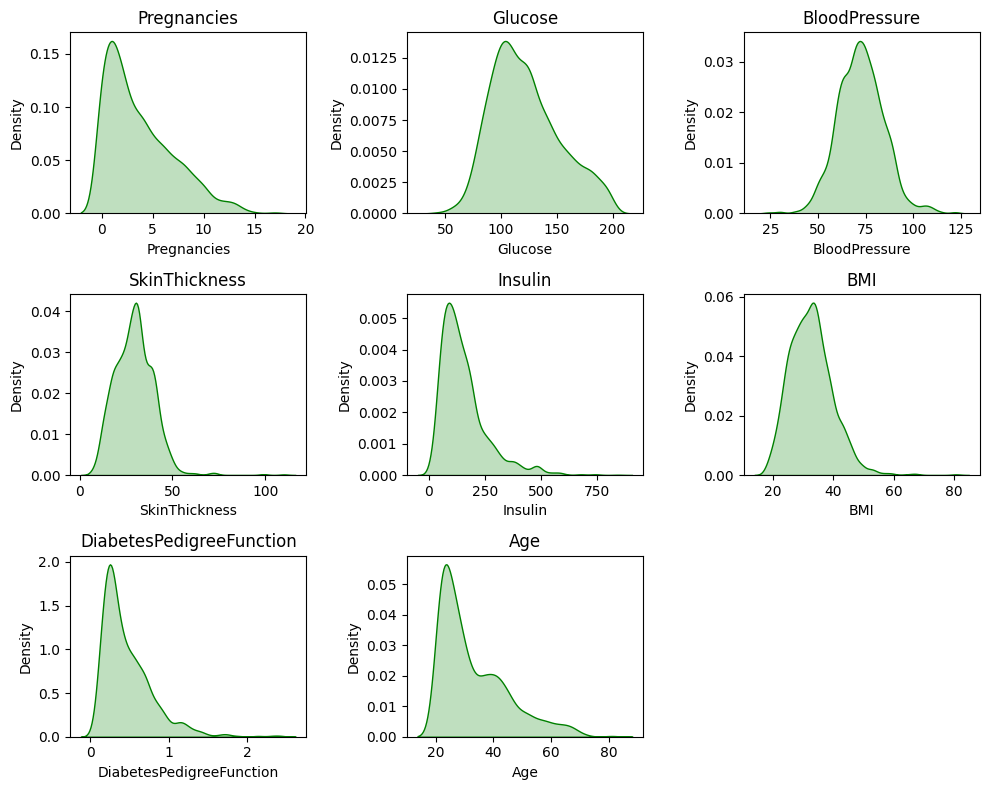

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

rows, cols = (3, 3)
plt.figure(figsize=(10, 8))

num_columns = df.select_dtypes(include=[np.number]).columns.tolist()

num_columns.remove('Outcome')
num_columns.remove('Id')

for i, col in enumerate(num_columns):
    plt.subplot(rows, cols, i+1)
    plt.title(col)
    sns.kdeplot(df[col], fill=True, color='g')

plt.tight_layout()
plt.show()

**Applying log transformation to the data to vissualize if the skewness is reduced**

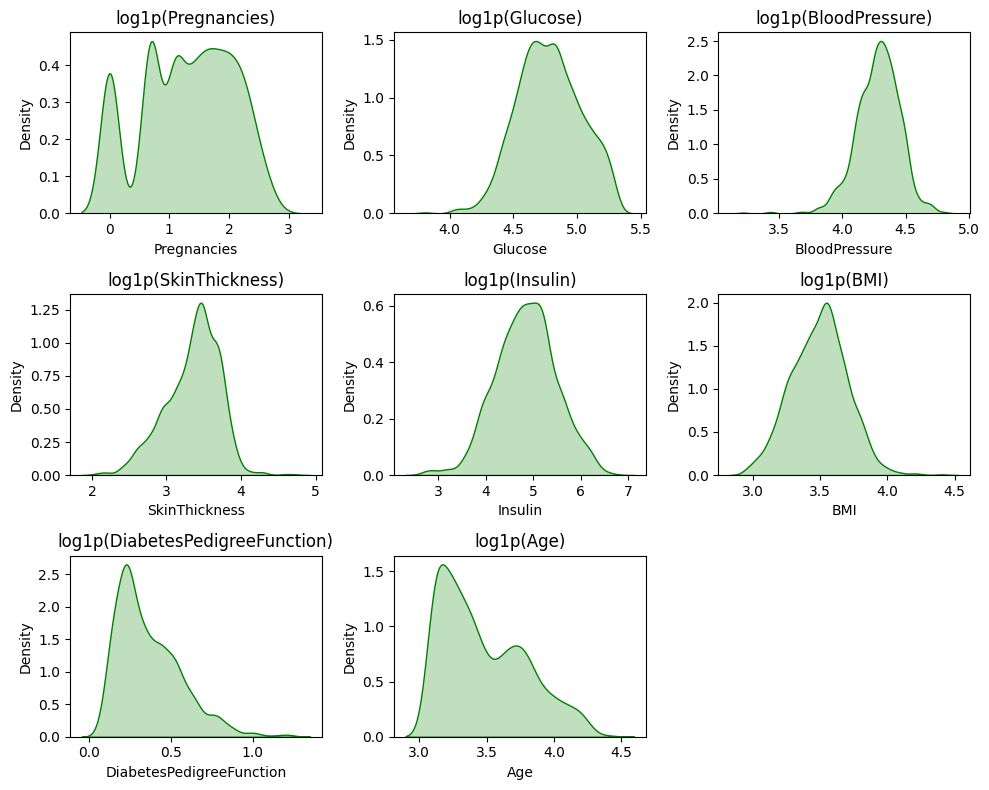

In [4]:
rows, cols = (3, 3)
plt.figure(figsize=(10, 8))

num_columns = df.select_dtypes(include=[np.number]).columns.tolist()

num_columns.remove('Outcome')
num_columns.remove('Id')

for i, col in enumerate(num_columns):

    plt.subplot(rows, cols, i+1)
    plot_data = df[col]
    
    plot_data = np.log1p(plot_data)
    plt.title(f'log1p({col})')

    sns.kdeplot(plot_data, fill=True, color='g')

plt.tight_layout()
plt.show()

Skewness of SkinThickness, Insulun, BMI is reduced, we can perform log transformation on these columns before sending to the model

In [5]:
X = df.drop(columns=['Outcome', 'Id'])
y = df['Outcome']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
y_train.value_counts()

Outcome
0    1453
1     761
Name: count, dtype: int64

The data as we know is imbalanced, we can either use class weights or evalue using precision, recall, f1 score instead of accuracy

### Understanding Which Evaluation Metrics to Use

* **Type 1 Error (False Positive):** Predicting a healthy patient diabetic
* **Type 2 Error (False Negative):** Predicting a diabetic patient healthy

In this scenario, reducing Type 2 errors is crucial because missing a diagnosis can have severe consequences for the patient’s health.

However, we will use the F1 score to strike a balance between Type 1 and Type 2 errors.

### Linear Regression Model with Log Transformation

In [8]:
def log_transform(x):
    return np.log1p(x)

In [9]:
cols_to_log_transform = ['SkinThickness', 'Insulin', 'BMI']

log_transformer = ColumnTransformer(
    transformers=[
        ('log_transform', FunctionTransformer(log_transform), cols_to_log_transform)
    ],
    remainder='passthrough'
)

pipeline = Pipeline([
        ('log_transformer', log_transformer),
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(class_weight='balanced', random_state=42))
    ]
)

pipeline.fit(X_train, y_train)

,steps,"[('log_transformer', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('log_transform', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [10]:
y_pred = pipeline.predict(X_test)

In [11]:
print(f'Accuracy Score: {accuracy_score(y_test, y_pred)}')

print(f'Recall Score: {recall_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred)}')

Accuracy Score: 0.7653429602888087
Recall Score: 0.7225130890052356
F1 Score: 0.6798029556650246


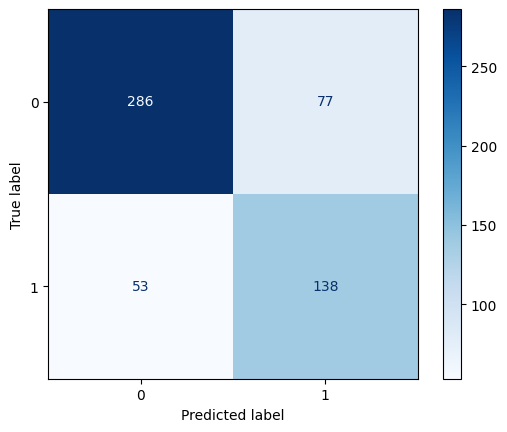

In [12]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.show()

In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.79      0.81       363
           1       0.64      0.72      0.68       191

    accuracy                           0.77       554
   macro avg       0.74      0.76      0.75       554
weighted avg       0.77      0.77      0.77       554



### Logistic Regression without log transformation

In [14]:
pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(class_weight='balanced', random_state=42))
    ]
)

pipeline.fit(X_train, y_train)

,steps,"[('scaler', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


In [15]:
y_pred = pipeline.predict(X_test)

In [16]:
print(f'Accuracy Score: {accuracy_score(y_test, y_pred)}')

print(f'Recall Score: {recall_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred)}')

Accuracy Score: 0.7653429602888087
Recall Score: 0.7172774869109948
F1 Score: 0.6782178217821783


In [17]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.79      0.82       363
           1       0.64      0.72      0.68       191

    accuracy                           0.77       554
   macro avg       0.74      0.75      0.75       554
weighted avg       0.77      0.77      0.77       554



In [18]:
# Save model
with open('./../models/logistic_regression_model.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

Both Logistic Regression models showed similar performance.

### Decision Tree

In [19]:
def dt_objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'class_weight': 'balanced',
        'random_state': 42
    }
    
    clf = DecisionTreeClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = f1_score(y_test, y_pred)

    return score

In [20]:
study_dt = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study_dt.optimize(dt_objective, n_trials=100)

[I 2025-10-05 19:23:55,335] A new study created in memory with name: no-name-7e76b17c-d062-444f-8b81-0572116f98e3
[I 2025-10-05 19:23:55,349] Trial 0 finished with value: 0.728110599078341 and parameters: {'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 8, 'criterion': 'gini'}. Best is trial 0 with value: 0.728110599078341.
[I 2025-10-05 19:23:55,349] Trial 1 finished with value: 0.6758349705304518 and parameters: {'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 9, 'criterion': 'entropy'}. Best is trial 0 with value: 0.728110599078341.
[I 2025-10-05 19:23:55,349] Trial 2 finished with value: 0.6023391812865497 and parameters: {'max_depth': 2, 'min_samples_split': 10, 'min_samples_leaf': 9, 'criterion': 'gini'}. Best is trial 0 with value: 0.728110599078341.
[I 2025-10-05 19:23:55,365] Trial 3 finished with value: 0.6748466257668712 and parameters: {'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 6, 'criterion': 'gini'}. Best is trial 0 with value: 0

In [21]:
trial_dt = study_dt.best_trial

print('Best trial parameters:', trial_dt.params)
print('Best trial F1-score:', trial_dt.value)

Best trial parameters: {'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'entropy'}
Best trial F1-score: 0.8932038834951457


In [22]:
dt_model = DecisionTreeClassifier(**trial_dt.params)
dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)

print(classification_report(y_test, y_pred))
print()

print(f'Recall Score: {recall_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred)}')

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       363
           1       0.89      0.88      0.89       191

    accuracy                           0.92       554
   macro avg       0.92      0.91      0.92       554
weighted avg       0.92      0.92      0.92       554


Recall Score: 0.8848167539267016
F1 Score: 0.8894736842105263


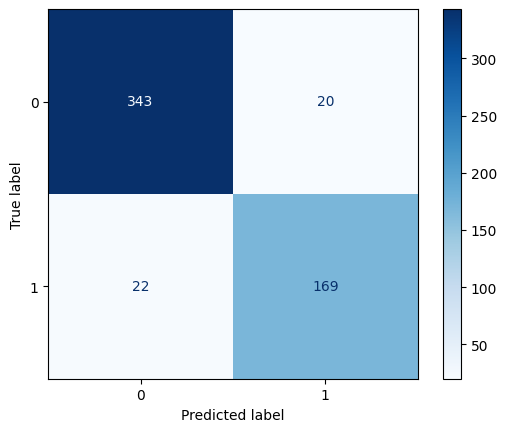

In [23]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.show()

In [24]:
# Save model
with open('./../models/decision_tree_model.pkl', 'wb') as file:
    pickle.dump(dt_model, file)

### Random Forest

In [25]:
def rf_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'class_weight': 'balanced',
        'random_state': 42,
        'n_jobs': -1
    }
    
    clf = RandomForestClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = f1_score(y_test, y_pred)

    return score

In [26]:
study_rf = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study_rf.optimize(rf_objective, n_trials=100)

[I 2025-10-05 19:23:56,585] A new study created in memory with name: no-name-4597b96b-9a3a-41e0-91be-1579a3a0f8b7
[I 2025-10-05 19:23:56,775] Trial 0 finished with value: 0.8894348894348895 and parameters: {'n_estimators': 144, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 6, 'criterion': 'gini'}. Best is trial 0 with value: 0.8894348894348895.
[I 2025-10-05 19:23:56,870] Trial 1 finished with value: 0.851581508515815 and parameters: {'n_estimators': 64, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 8, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8894348894348895.
[I 2025-10-05 19:23:57,148] Trial 2 finished with value: 0.7149532710280374 and parameters: {'n_estimators': 258, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8894348894348895.
[I 2025-10-05 19:23:57,327] Trial 3 finished with value: 0.765375854214123 and parameters: {'n_estimators': 158, 'max_depth': 4, 'min_sample

In [27]:
trial_rf = study_rf.best_trial

print('Best trial parameters:', trial_rf.params)
print('Best trial F1-score:', trial_rf.value)

Best trial parameters: {'n_estimators': 176, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'entropy'}
Best trial F1-score: 0.9669211195928753


In [28]:
rf_model = RandomForestClassifier(**trial_rf.params)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print(classification_report(y_test, y_pred))
print()

print(f'Recall Score: {recall_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred)}')

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       363
           1       0.96      0.96      0.96       191

    accuracy                           0.97       554
   macro avg       0.97      0.97      0.97       554
weighted avg       0.97      0.97      0.97       554


Recall Score: 0.9633507853403142
F1 Score: 0.9608355091383812


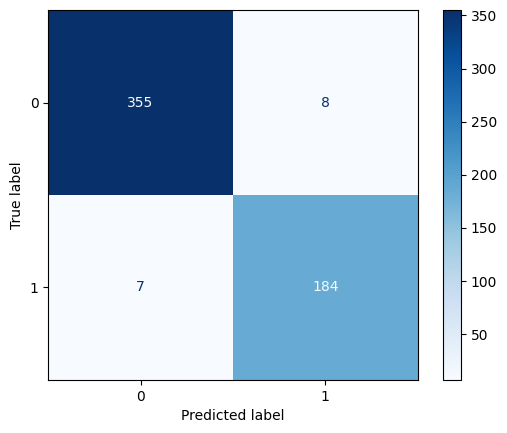

In [29]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.show()

In [30]:
# Save model
with open('./../models/random_forest_model.pkl', 'wb') as file:
    pickle.dump(rf_model, file)

### Gradient Boosting Decision Tree

In [31]:
def gbdt_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'random_state': 42
    }
    model = GradientBoostingClassifier(**params)
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='f1_macro').mean()
    
    return score

In [32]:
study_gbdt = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study_gbdt.optimize(gbdt_objective, n_trials=100)

[I 2025-10-05 19:24:18,405] A new study created in memory with name: no-name-b53b1d0c-83e2-45da-8bfc-0bd401d203f8
[I 2025-10-05 19:24:20,464] Trial 0 finished with value: 0.9542368872143339 and parameters: {'n_estimators': 144, 'learning_rate': 0.28570714885887566, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 0 with value: 0.9542368872143339.
[I 2025-10-05 19:24:20,835] Trial 1 finished with value: 0.8653793669454314 and parameters: {'n_estimators': 200, 'learning_rate': 0.21534104756085318, 'max_depth': 2, 'min_samples_split': 10, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9542368872143339.
[I 2025-10-05 19:24:21,840] Trial 2 finished with value: 0.9487440824362269 and parameters: {'n_estimators': 126, 'learning_rate': 0.16217936517334897, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 0 with value: 0.9542368872143339.
[I 2025-10-05 19:24:22,29

In [33]:
trial_gbdt = study_gbdt.best_trial

print('Best trial parameters:', trial_gbdt.params)
print('Best trial F1-score:', trial_gbdt.value)

Best trial parameters: {'n_estimators': 59, 'learning_rate': 0.17724061551723877, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'sqrt'}
Best trial F1-score: 0.9627293295465827


In [34]:
gbdt_model = GradientBoostingClassifier(**trial_gbdt.params)
gbdt_model.fit(X_train, y_train)
y_pred = gbdt_model.predict(X_test)

print(classification_report(y_test, y_pred))
print()

print(f'Recall Score: {recall_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred)}')

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       363
           1       1.00      0.99      0.99       191

    accuracy                           1.00       554
   macro avg       1.00      0.99      1.00       554
weighted avg       1.00      1.00      1.00       554


Recall Score: 0.9895287958115183
F1 Score: 0.9947368421052631


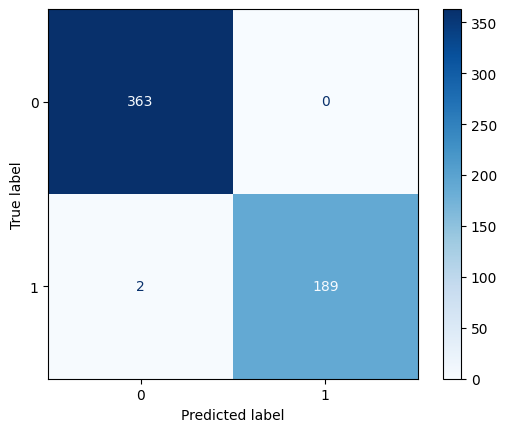

In [35]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.show()

In [36]:
# save model
with open('./../models/gradient_boosting_model.pkl', 'wb') as file:
    pickle.dump(gbdt_model, file)

### XGBoost

In [37]:
def xgb_objective(trial):
    params = {
        'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'device': 'cuda',
        'random_state': 42
    }

    model = XGBClassifier(**params)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_macro').mean()

    return score

In [38]:
study_xgb = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study_xgb.optimize(xgb_objective, n_trials=75)

[I 2025-10-05 19:25:56,496] A new study created in memory with name: no-name-1c3097a2-fe70-474a-aee7-bc84e43d52ab
c:\Users\H477237\project\Diabetes-classification\.venv\Lib\site-packages\xgboost\core.py:729: UserWarning: [19:26:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
[I 2025-10-05 19:26:25,702] Trial 0 finished with value: 0.8538932724513021 and parameters: {'booster': 'dart', 'eta': 0.22227824312530747, 'n_estimators': 200, 'learning_rate': 0.055245405728306586, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.9330880728874675}. Best i

In [39]:
trial_xgb = study_xgb.best_trial
print('Best trial parameters:', trial_xgb.params)
print('Best trial F1-score:', trial_xgb.value)

Best trial parameters: {'booster': 'gbtree', 'eta': 0.11952303534703317, 'n_estimators': 249, 'learning_rate': 0.1421779631412263, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.8684023342185442}
Best trial F1-score: 0.9784083970068324


In [40]:
xgb_model = XGBClassifier(**trial_xgb.params)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

print(classification_report(y_test, y_pred))
print()

print(f'Recall Score: {recall_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred)}')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       363
           1       1.00      0.99      1.00       191

    accuracy                           1.00       554
   macro avg       1.00      1.00      1.00       554
weighted avg       1.00      1.00      1.00       554


Recall Score: 0.9947643979057592
F1 Score: 0.9973753280839895


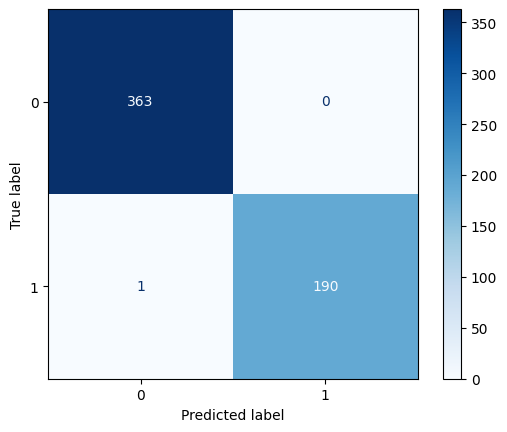

In [41]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.show()

In [43]:
# Save model
with open('./../models/XGBoost_model.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)

### Model's Performance Summary

| Model          | Training F1 Score | Testing F1 Score |
|----------------|--------------------|-------------------|
| Decision Tree  | 89.32              | 88.95             |
| Random Forest  | 96.69              | 96.08             |
| GBDT           | 96.27              | 99.47             |
| XGBoost        | 97.84              | 99.73             |

XGBoost has outperformed the other models to a small extent.